# Model Improvement After Feedback (10/09)

We show the desired outcome (**L1** and **L2** products on the full time series) with the continuous integration setup.  

To reduce the willingness of the data, we add a local filter which consider as outlier an observation based on the local delta distribution.

We will only consider the **forecasted data**, since the retroactive gapfilled data are identical.  

---

## Improvements

The improvements are the following:  

- adding a local filter to reduce the data willingness
- Including a multiplicative factor to avoid unwanted behavior  
- Testing the three different smoothing options


In [9]:
from IPython.display import IFrame, Image, display
import numpy as np
import math
import zarr
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import xarray as xr
import torch
import torch.nn as nn
import pandas as pd
from scipy.signal import savgol_filter
import gc
import imageio
from io import BytesIO
from affine import Affine
from functions import *

This is the full gapfilled time serie with the smoothing using Savitzky Golay

In [10]:
# data loading and raster initialization
# ----- Config -----
zarr_path = "../pixel_biomes.zarr/ndvi"

z = zarr.open(zarr_path, mode="r")

# fitting and smoothing
# ----- seasonal cycle fitting -----
ds = xr.open_zarr("../../sample_seasonal_cycle_parameter_preds.zarr")
ndvi = ds["ndvi"]
dates = ds["dates"]
params_lower = torch.tensor(ds["params_lower"].values)
params_upper = torch.tensor(ds["params_upper"].values)

# convert dates to doy
dates_pd = pd.to_datetime(dates)
df = pd.DataFrame({"date": dates_pd})
df_sorted = df.sort_values(by="date")
dates_sorted = df_sorted["date"].values
dates_pd_sorted = pd.to_datetime(dates_sorted)
doy = dates_pd_sorted.dayofyear.values
doy = torch.tensor(doy, dtype=torch.float32)
T_SCALE = 1.0 / 365.0
t = doy.unsqueeze(0).repeat(params_lower.shape[0], 1) * T_SCALE


lower = double_logistic_function(t[[0]], params_lower[[91]]).squeeze().cpu().numpy()
upper = double_logistic_function(t[[0]], params_upper[[91]]).squeeze().cpu().numpy()

median_iqr = upper - (upper - lower) / 2

param_iqr = 1.02
bottom_iqr = 0.2
upper_iqr = 0.8
window_length = 14
polyorder = 2

random_pixels = 120  # pick one pixel index to check

ndvi_series = z[random_pixels, :]

# proper sorting

df = pd.DataFrame({
    'date': dates_pd,
    'ndvi': ndvi_series
    })

df_sorted = df.sort_values(by='date')

ndvi_sorted = df_sorted['ndvi'].values

ndvi_gapfilled, outlier_arr, q_hi, q_low, delta_diff, iqr_param, smoothed,valid_outlier, valid_idx, deltas = gapfill_ndvi(ndvi_sorted, lower, upper,forecasting=False,
                                            param_iqr=1.02,bottom_q=0.4,
                                            top_q=0.6,return_quantiles = True, weight_median = 0.5,smoothing_method = "savgol")



/home/francesco/miniconda3/envs/ndvi/lib/python3.11/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/home/francesco/data_scratch/swiss-ndvi-processing/demo/notebook/functions.py:114: RuntimeWarning: divide by zero encountered in divide
  iqr_param = np.where(valid_ndvi / median_valid < 1, median_valid / valid_ndvi, valid_ndvi / median_valid)
/home/francesco/data_scratch/swiss-ndvi-processing/demo/notebook/functions.py:209: RuntimeWarning: divide by zero encountered in divide
  ratio = np.maximum(valid_ndvi, median_valid) / np.minimum(valid_ndvi, median_valid)


Here we mimick the minimum amount of data necessary to mimick the outlier detection not haveing access to the ful time series

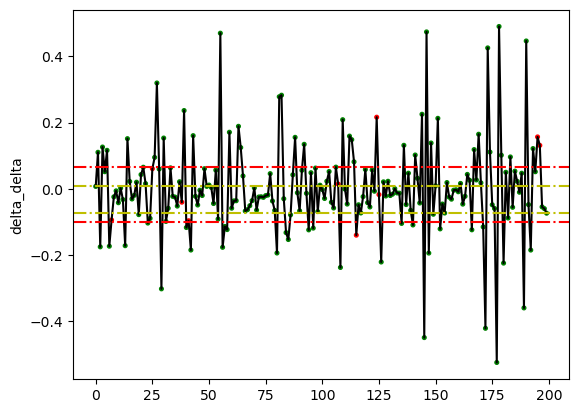

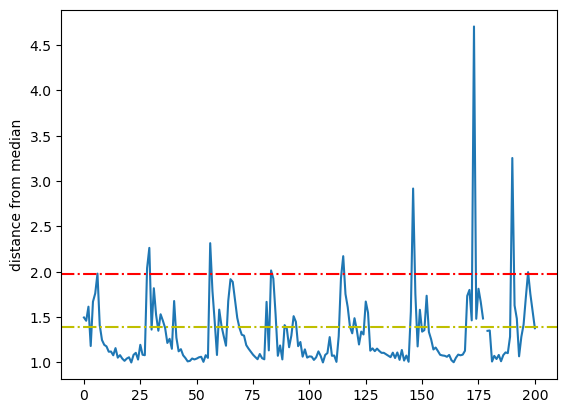

In [11]:
y_delta_l , y_delta_h,r_delta_h, r_delta_l  = np.quantile(delta_diff, [0.2,0.6,0.8,0.15])
y_iqr, r_iqr = np.quantile(iqr_param, [0.7, 0.95])


ndvi_series_2 = ndvi_series.astype(float) / 10000.0
ndvi_series_2 = np.where((ndvi_series_2 > 1) | (ndvi_series_2 < 0), np.nan, ndvi_series_2)

valid_idx = np.where(np.isfinite(ndvi_series_2))[0]

outlier_arr_2 = outlier_arr[valid_idx]
outlier_arr_2 =  np.where(outlier_arr_2, "red", "green")


plt.plot(np.arange(0,len(delta_diff)),delta_diff, color = "black")
plt.scatter(np.arange(0,len(delta_diff)),delta_diff, color = outlier_arr_2[1:], s=7)
plt.axhline(y=y_delta_l, color='y', linestyle='-.')
plt.axhline(y=y_delta_h, color='y', linestyle='-.')
plt.axhline(y=r_delta_l, color='r', linestyle='-.')
plt.axhline(y=r_delta_h, color='r', linestyle='-.')
plt.ylabel("delta_delta")  
plt.show()

plt.plot(np.arange(0,len(iqr_param)),iqr_param)
plt.axhline(y=y_iqr, color='y', linestyle='-.')
plt.axhline(y=r_iqr, color='r', linestyle='-.')
plt.ylabel("distance from median")  
plt.show()

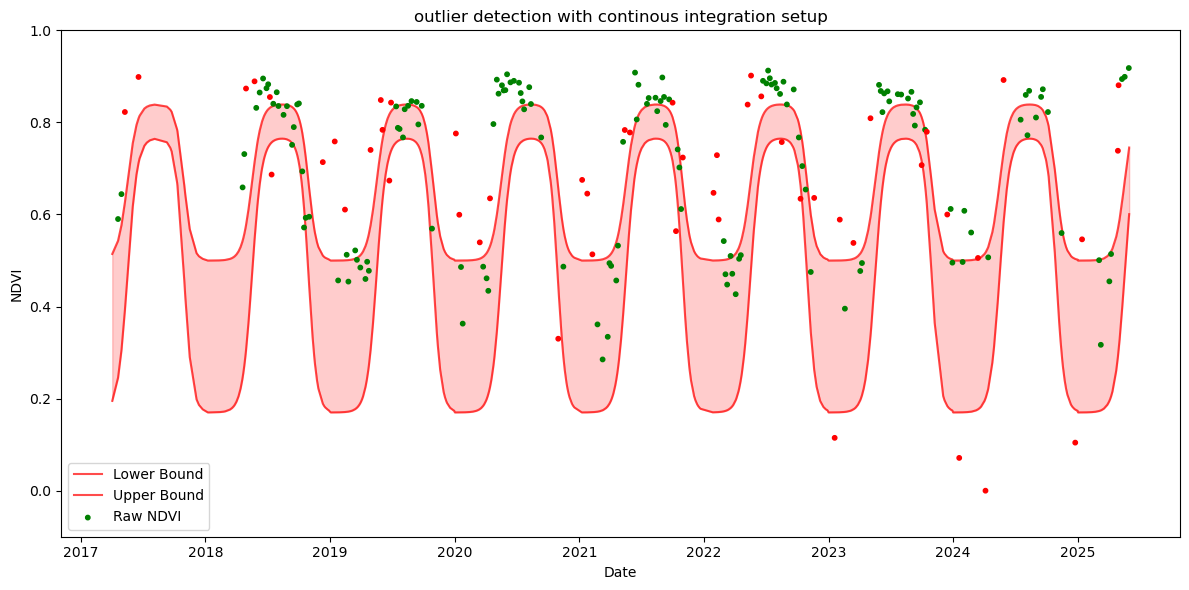

In [12]:
ndvi_gapfilled, outlier_mask, smoothed, valid_outlier, valid_idx, deltas = gapfill_ndvi(ndvi_sorted, lower, upper,
                                                                                            forecasting=False,
                                                                                            param_iqr=1.5,
                                                                                            bottom_q=0.3,
                                                                                            top_q=0.7,
                                                                                            weight_median = 0.5,
                                                                                            y_delta_l = y_delta_l, 
                                                                                            y_delta_h =y_delta_h,
                                                                                            r_delta_h =r_delta_h, 
                                                                                            r_delta_l =r_delta_l, 
                                                                                            y_iqr = y_iqr,
                                                                                            r_iqr = r_iqr,
                                                                                            window_smoothing = 14,
                                                                                            use_tau= True,
                                                                                            tau = 7,
                                                                                            lag_forecast= 14
                                                                                            )


colors = np.where(outlier_arr, "red", "green")

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(dates_sorted, lower, label="Lower Bound", color="red", alpha=0.7)
ax.plot(dates_sorted, upper, label="Upper Bound", color="red", alpha=0.7)
ax.fill_between(dates_sorted, lower, upper, alpha=0.2, color="red")

ax.scatter(dates_sorted, ndvi_sorted / 10000.0, s=10, color=colors, label="Raw NDVI", zorder=3)


ax.set_title("outlier detection with continous integration setup")
ax.set_ylim(-0.1, 1.0)
ax.set_xlabel("Date")
ax.set_ylabel("NDVI")
ax.legend()
plt.tight_layout()




In [16]:
# not delete
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
import statsmodels.api as sm
import torch

# -- filter obs
ndvi_series_2 = ndvi_sorted.astype(float) / 10000.0
ndvi_series_2 = np.where((ndvi_series_2 > 1) | (ndvi_series_2 < 0), np.nan, ndvi_series_2)

valid_idx = np.where(np.isfinite(ndvi_series_2))[0]

outlier_arr_2 = outlier_arr[valid_idx]
outlier_arr_2 =  np.where(outlier_arr_2, "red", "green")

ndvi_series_2 = ndvi_series_2[valid_idx]
ndvi_series_2 = ndvi_series_2[outlier_arr_2 == 'green']

# --- filter valid dates ---
dates_sorted_2 = dates_sorted[valid_idx]
dates_sorted_2 = dates_sorted_2[outlier_arr_2 == 'green']
deltas_2 = deltas[outlier_arr_2 == 'green']



# --- DataFrames for deltas and observations ---
df_smooth = pd.DataFrame({
    'date': dates_sorted_2,   # shift because delta-delta
    'deltas': deltas_2,
    "obs": ndvi_series_2
})

# --- preprocessing ---
df_smooth["date"] = pd.to_datetime(df_smooth["date"])
df_smooth = df_smooth.set_index("date").sort_index()

# --- 1. Smooth only existing observations ---
values = df_smooth["deltas"].values
n = len(values)

# Savitzky–Golay smoothing
window = min(14, n if n % 2 == 1 else n - 1)  # must be odd
if window >= 3:
    smooth_obs = savgol_filter(values, window_length=window, polyorder=2)
else:
    smooth_obs = values.copy()
df_smooth["smooth_obs"] = smooth_obs

# Gaussian smoothing
df_smooth["smooth_gauss"] = gaussian_filter1d(values, sigma=2)

# LOESS smoothing
idx = np.arange(n)
loess = sm.nonparametric.lowess(values, idx, frac=0.05, return_sorted=True)
df_smooth["smooth_loess"] = np.interp(idx, loess[:, 0], loess[:, 1])

# --- 2. Reindex to full daily series ---
full_index = pd.date_range(df_smooth.index.min(), df_smooth.index.max(), freq="D")
df_daily = df_smooth.reindex(full_index)

# --- 3. Fill missing days using smoothed values ---
for col in ["smooth_obs", "smooth_gauss", "smooth_loess"]:
    df_daily[col] = df_daily[col].interpolate(method="time")

# --- 4. Calculate envelopes (lower/upper/median) ---
doy = df_daily.index.dayofyear.values
doy = torch.tensor(doy, dtype=torch.float32)

T_SCALE = 1.0 / 365.0
t = doy.unsqueeze(0).repeat(params_lower.shape[0], 1) * T_SCALE   # (n_params, n_days)

lower = double_logistic_function(t[[0]], params_lower[[91]]).squeeze().cpu().numpy()
upper = double_logistic_function(t[[0]], params_upper[[91]]).squeeze().cpu().numpy()
median_iqr = 0.5 * (lower + upper)

df_daily["median"] = median_iqr

# visualize deltas

print(df_daily)

              deltas     obs  smooth_obs  smooth_gauss  smooth_loess    median
2017-04-20  0.195787  0.5901    0.251284      0.219845      0.210075  0.394313
2017-04-21       NaN     NaN    0.249484      0.220152      0.209709  0.398054
2017-04-22       NaN     NaN    0.247685      0.220459      0.209343  0.401991
2017-04-23       NaN     NaN    0.245885      0.220766      0.208977  0.406132
2017-04-24       NaN     NaN    0.244086      0.221073      0.208611  0.410480
...              ...     ...         ...           ...           ...       ...
2025-05-26       NaN     NaN    0.300699      0.275786      0.322330  0.637537
2025-05-27       NaN     NaN    0.304212      0.276951      0.327234  0.644997
2025-05-28       NaN     NaN    0.307725      0.278117      0.332138  0.652290
2025-05-29       NaN     NaN    0.311238      0.279283      0.337042  0.659403
2025-05-30  0.251773  0.9181    0.314751      0.280449      0.341947  0.666327

[2963 rows x 6 columns]


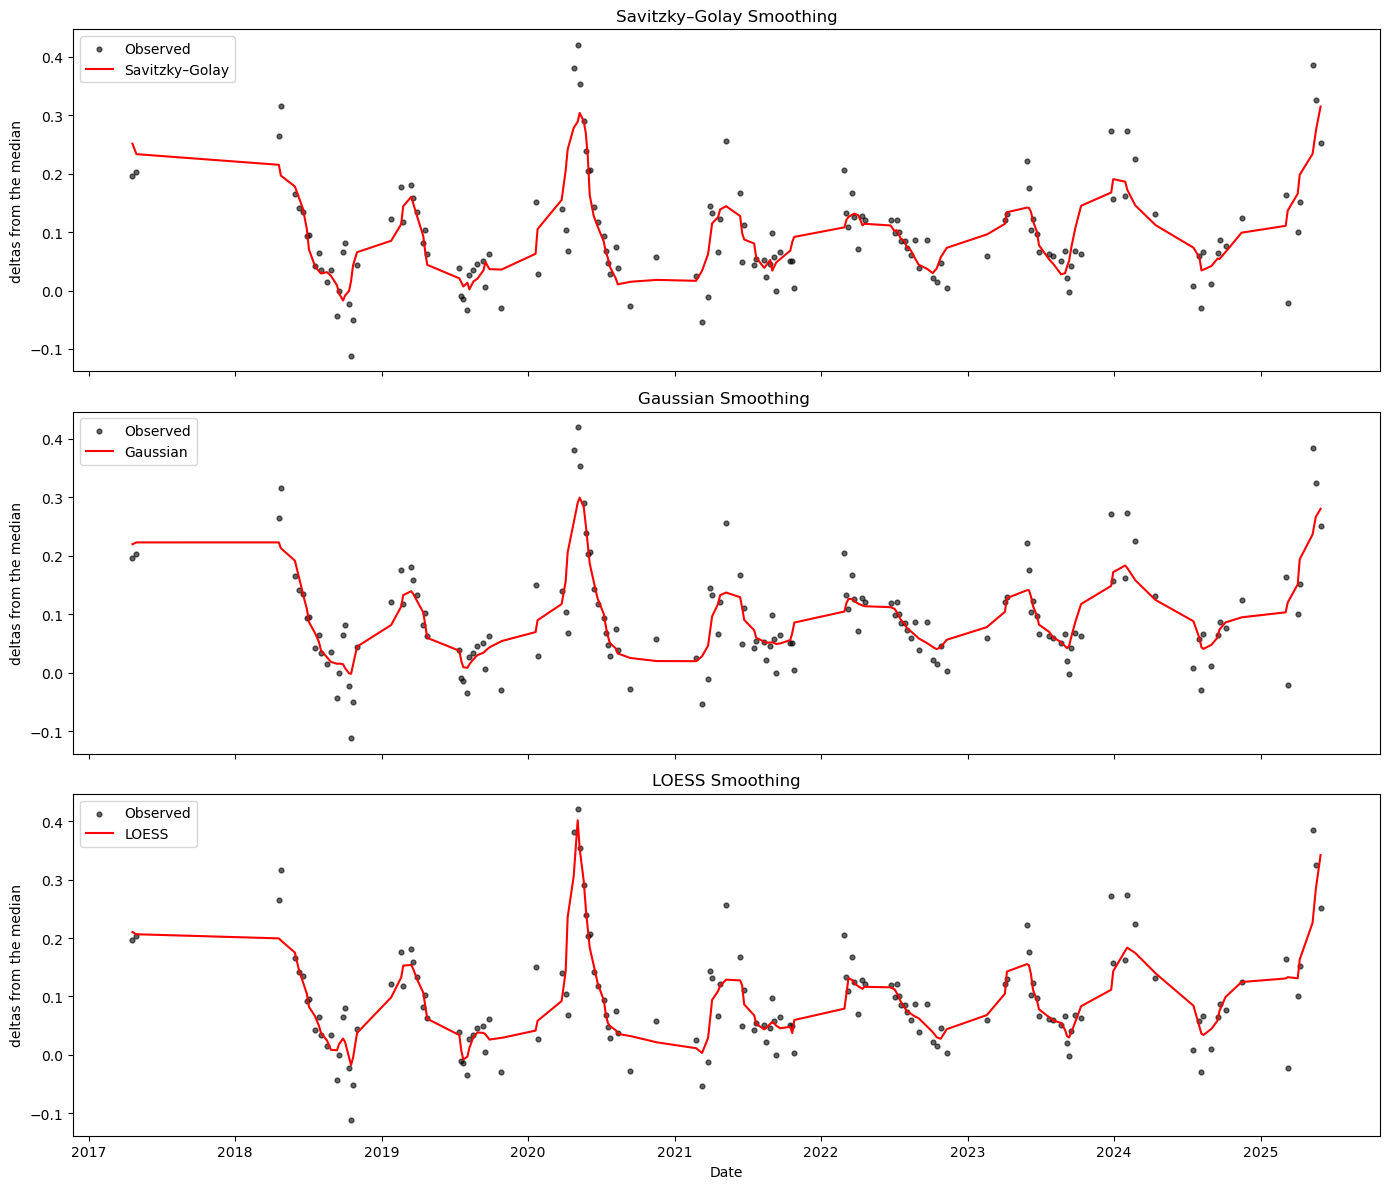

In [17]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)


# --- Plot 1: Savitzky–Golay ---
axes[0].scatter(df_daily.index, df_daily["deltas"], s=12, color="black", alpha=0.6, label="Observed")
axes[0].plot(df_daily.index, df_daily["smooth_obs"], color="red", label="Savitzky–Golay")
axes[0].set_title("Savitzky–Golay Smoothing")
axes[0].legend()

# --- Plot 2: Gaussian ---
axes[1].scatter(df_daily.index, df_daily["deltas"], s=12, color="black", alpha=0.6, label="Observed")
axes[1].plot(df_daily.index, df_daily["smooth_gauss"], color="red", label="Gaussian")
axes[1].set_title("Gaussian Smoothing ")
axes[1].legend()

# --- Plot 3: LOESS ---
axes[2].scatter(df_daily.index, df_daily["deltas"], s=12, color="black", alpha=0.6, label="Observed")
axes[2].plot(df_daily.index, df_daily["smooth_loess"], color="red", label="LOESS")
axes[2].set_title("LOESS Smoothing")
axes[2].legend()

# --- Global formatting ---
for ax in axes:
    ax.set_ylabel("deltas from the median")
axes[-1].set_xlabel("Date")

plt.tight_layout()
plt.show()


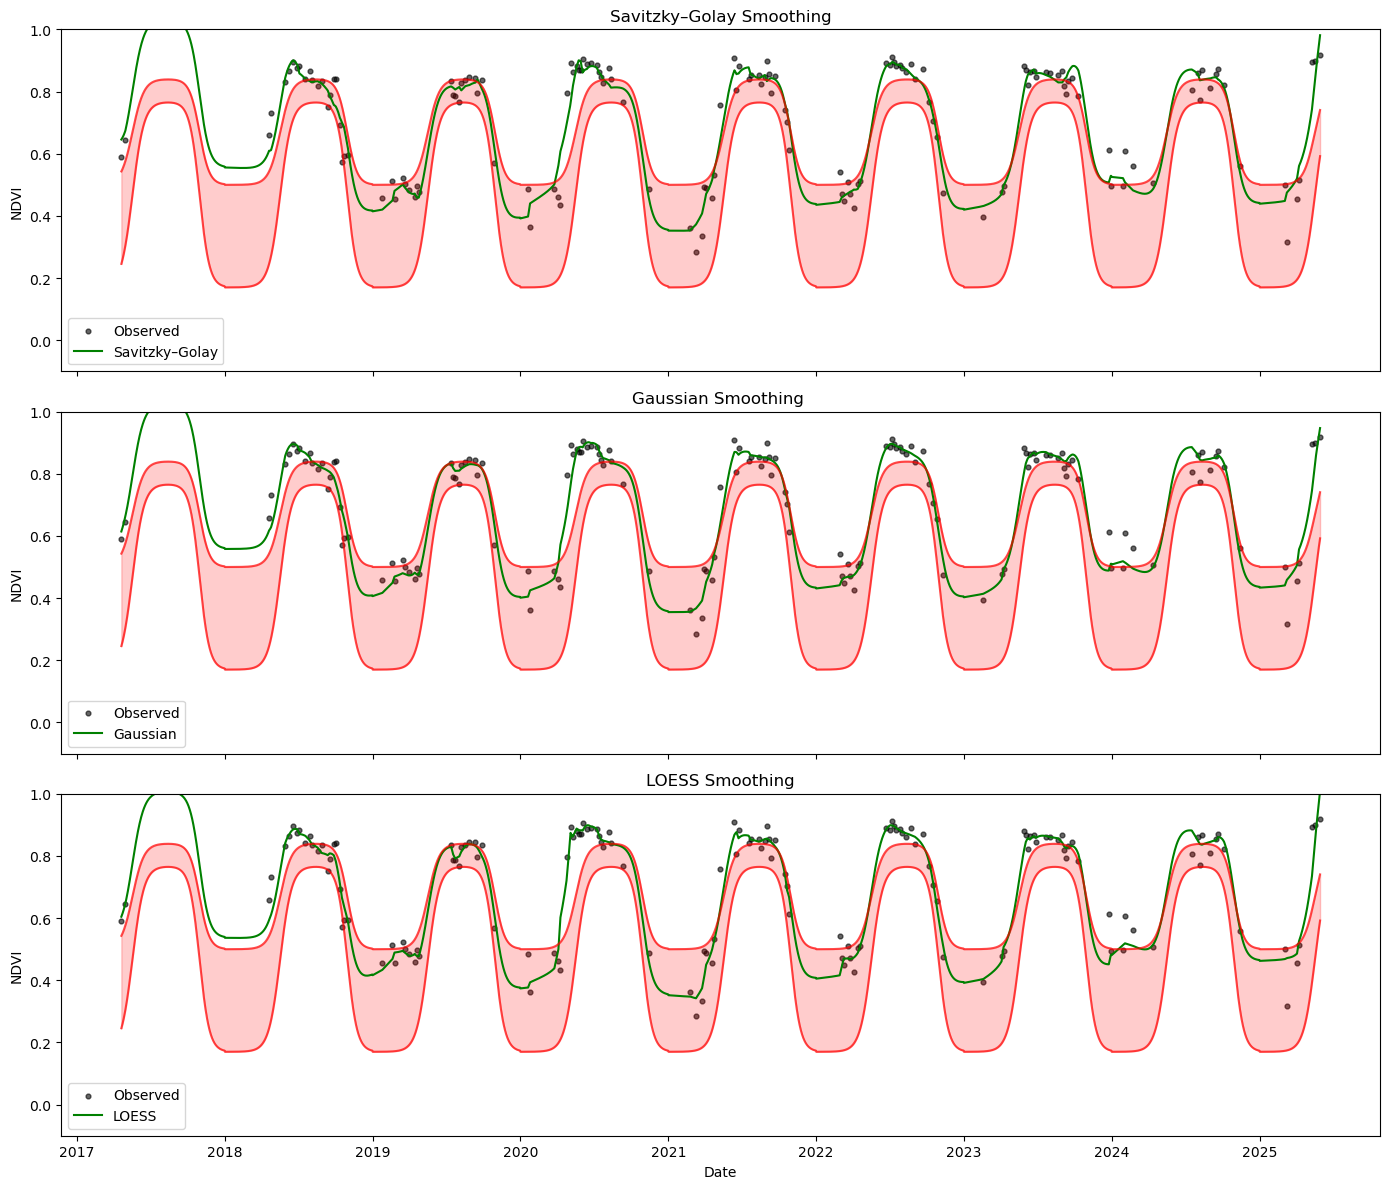

In [18]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)


# --- Plot 1: Savitzky–Golay ---
axes[0].scatter(df_daily.index, df_daily["obs"], s=12, color="black", alpha=0.6, label="Observed")
axes[0].plot(df_daily.index, df_daily["smooth_obs"] + df_daily["median"], color="green", label="Savitzky–Golay")
axes[0].set_title("Savitzky–Golay Smoothing")
axes[0].legend()

# --- Plot 2: Gaussian ---
axes[1].scatter(df_daily.index, df_daily["obs"], s=12, color="black", alpha=0.6, label="Observed")
axes[1].plot(df_daily.index, df_daily["smooth_gauss"] + df_daily["median"], color="green", label="Gaussian")
axes[1].set_title("Gaussian Smoothing ")
axes[1].legend()

# --- Plot 3: LOESS ---
axes[2].scatter(df_daily.index, df_daily["obs"], s=12, color="black", alpha=0.6, label="Observed")
axes[2].plot(df_daily.index, df_daily["smooth_loess"] + df_daily["median"], color="green", label="LOESS")
axes[2].set_title("LOESS Smoothing")
axes[2].legend()

# --- Global formatting ---
for ax in axes:
    ax.set_ylabel("NDVI")
    ax.plot(df_daily.index, lower, label="Lower Bound", color="red", alpha=0.7)
    ax.plot(df_daily.index, upper, label="Upper Bound", color="red", alpha=0.7)
    ax.fill_between(df_daily.index, lower, upper, alpha=0.2, color="red")
    ax.set_ylim(-0.1, 1.0)
axes[-1].set_xlabel("Date")

plt.tight_layout()
plt.show()
